In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras import backend as K

Using TensorFlow backend.


In [2]:
#import data
train_data = pd.read_csv('train.csv')
print('The size of the whole training data that we have is {}'.format(train_data.shape[0]))

The size of the whole training data that we have is 159571


In [3]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import word2vec

In [4]:
#randomly draw 10000 data points from the training data. 
train_sample = train_data.sample(n=10000, random_state=42)
print('The size of training sample that we use for trianing is {}'.format(train_sample.shape[0]))

The size of training sample that we use for trianing is 10000


In [5]:
raw_sentence=list(train_sample['comment_text'])
raw_sentence[1]

'Carioca RFA \n\nThanks for your support on my request for adminship.\n\nThe final outcome was (31/4/1), so I am now an administrator. If you have any comments or concerns on my actions as an administrator, please let me know. Thank you!'

In [9]:
#prepare the corpus
sentence=[]
for i in raw_sentence:
    sentence.append(keras.preprocessing.text.text_to_word_sequence(i,
                                               filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
                                               lower=True,
                                               split=" "))

In [6]:
#train the word2vec model
#!!!Please skip this cell and run the next cell to load the model instead
#It is be very time consuming
model = word2vec.Word2Vec(sentence, size=5,window=25,min_count=1,workers=5,sg=1,hs=1)

#save the model
model.save("word2vec_trainingdata_all_size25.model") 

In [6]:
#load the pre_trained model
model = word2vec.Word2Vec.load("word2vec_trainingdata_all_size25.model")

In [7]:
model.similar_by_word('woman',topn=10)

C:\Users\Yechen Wang\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('child', 0.9082338809967041),
 ('lipsynching', 0.9045818448066711),
 ('homosexual', 0.898306131362915),
 ('rakes', 0.8973876237869263),
 ('prostitute', 0.8971611261367798),
 ('parents', 0.896621823310852),
 ('teenage', 0.8909416198730469),
 ("versions'", 0.8904895186424255),
 ('naked', 0.8887367248535156),
 ("'acoustic", 0.8881762027740479)]

In [11]:
#show the word2vec for the word "woman"
model.wv['woman']

array([ 0.30875278, -0.09276484,  0.23439272, -0.12415814, -0.32714835,
       -0.7434549 ,  0.22729206,  0.5934643 ,  0.96459156,  0.21575618,
       -0.06617334,  0.19099374, -0.3154834 ,  0.38744846, -0.09151516,
       -0.40016758, -0.34886068,  0.4877205 , -0.23922376, -0.52211165,
        0.16920346, -0.30374384,  0.10103913,  0.3683711 ,  0.04831508],
      dtype=float32)

In [10]:
maxlen = max([len(x) for x in sentence])
maxlen

1344

In [11]:
def raw_sentence_to_word2vec_zeropadded(raw_sentence,model,maxlen):
    
    sentence=[]
    for i in raw_sentence:
        sentence.append(keras.preprocessing.text.text_to_word_sequence(i,
                                               filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
                                               lower=True,
                                               split=" "))

    for j in range(0,len(sentence)):
        for i in range(0,maxlen):
            if i<len(sentence[j]):
                #for the word not in vocabulary, we consider it as the zero vector
                try:
                    sentence[j][i]=model.wv[sentence[j][i]]
                except KeyError:
                    sentence[j][i]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

            else:
                sentence[j].append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    
    train_vector=np.array(sentence)
    train_vector=train_vector.reshape(len(raw_sentence),maxlen,25,1)
    return train_vector

In [12]:
#replace the word with word2vec
#!!! This takes more than 4G memories
#If you dont want to run this code, please ignore the next few cells and run the code includes loading instead
for j in range(0,len(sentence)):
    for i in range(0,maxlen):
        if i<len(sentence[j]):
            sentence[j][i]=model.wv[sentence[j][i]]
        else:
            sentence[j].append([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

In [13]:
#prepare the training input data (word2vec vectors that could represent the sentences)
train_vector=np.array(sentence)
train_vector=train_vector.reshape(10000,maxlen,25,1)
np.save("train_vector.npy",train_vector)
train_vector.shape

In [ ]:
#Please run this cell if you want to load the word2vec data
train_vector= np.load("train_vector.npy")

In [14]:
#prepare the training target data
y_toxic = train_sample['toxic']
y_toxic = keras.utils.to_categorical(y_toxic, 2)

In [16]:
# train validation split
from sklearn.model_selection import train_test_split
x_train_toxic, x_test_toxic, y_train_toxic, y_test_toxic = train_test_split(train_vector, y_toxic, test_size=0.1, random_state=42)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten

In [21]:
# construct model
# Modified text CNN

model_toxic = Sequential()

model_toxic.add(Conv2D(128, kernel_size=(2,25), activation='relu', input_shape=(maxlen,25,1)))
model_toxic.add(MaxPooling2D(pool_size=(maxlen-2+1,1)))
model_toxic.add(Flatten())
model_toxic.add(Dense(128, activation='relu'))
model_toxic.add(Dropout(0.25))
model_toxic.add(Dense(2, activation='softmax'))

model_toxic.summary()

model_toxic.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1343, 1, 128)      6528      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 23,298
Trainable params: 23,298
Non-trainable params: 0
__________________________________________________

In [28]:
#train on data
batch_size = 32
epochs = 10
history = model_toxic.fit(x_train_toxic, y_train_toxic,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_toxic, y_test_toxic))

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 7s 755us/step - loss: 0.0254 - accuracy: 0.9911 - val_loss: 0.2091 - val_accuracy: 0.9350
Epoch 2/10
9000/9000 [==============================] - 6s 718us/step - loss: 0.0237 - accuracy: 0.9924 - val_loss: 0.2042 - val_accuracy: 0.9450
Epoch 3/10
9000/9000 [==============================] - 6s 710us/step - loss: 0.0195 - accuracy: 0.9936 - val_loss: 0.2310 - val_accuracy: 0.9520
Epoch 4/10
9000/9000 [==============================] - 6s 706us/step - loss: 0.0167 - accuracy: 0.9944 - val_loss: 0.2818 - val_accuracy: 0.9530
Epoch 5/10
9000/9000 [==============================] - 7s 745us/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.2407 - val_accuracy: 0.9520
Epoch 6/10
9000/9000 [==============================] - 7s 771us/step - loss: 0.0194 - accuracy: 0.9939 - val_loss: 0.2642 - val_accuracy: 0.9480
Epoch 7/10
9000/9000 [==============================] - 6s 717us/step - loss

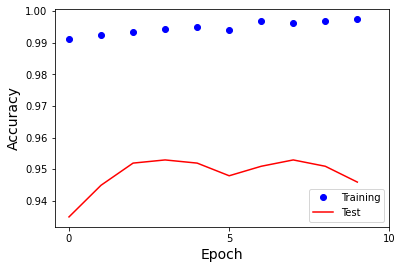

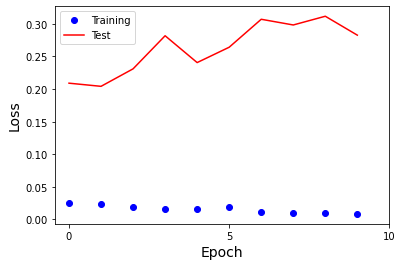

In [29]:
#show the evolution of accuracy and loss 

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_number = range(len(accuracy))

plt.plot(epoch_number, accuracy, 'bo', label='Training')
plt.plot(epoch_number, val_accuracy, 'r', label='Test')
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.xticks(np.arange(0, epochs+1, step=5))
plt.legend()
plt.show()

plt.figure()
plt.plot(epoch_number, loss, 'bo', label='Training')
plt.plot(epoch_number, val_loss, 'r', label='Test')
plt.xlabel('Epoch', size=14)
plt.ylabel('Loss', size=14)
plt.xticks(np.arange(0, epochs+1, step=5))
plt.legend()
plt.show()

In [30]:
#here you can modify the input list to see the prediction
play_test=raw_sentence_to_word2vec_zeropadded(['How are you','fuck you','I love you'],model,maxlen)

In [31]:
#make prediction
#if the first number is bigger, then the prediction is not toxic
#if the second number is bigger ,then the prediction is toxic
y_pred=model_toxic.predict(play_test)
y_pred

array([[9.7703403e-01, 2.2965917e-02],
       [5.3044721e-05, 9.9994695e-01],
       [9.4753706e-01, 5.2462950e-02]], dtype=float32)

In [32]:
#import test data
test_data = pd.read_csv('test.csv')
print('The size of test data that we have is {}'.format(test_data.shape[0]))
test_data.head()

The size of test data that we have is 153164


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [33]:
#import test result
test_label = pd.read_csv('test_labels.csv')
test_label.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [34]:
test_label = test_label[test_label['toxic']!=-1]
print('The number of valid test result that we have is {}'.format(test_label.shape[0]))

The number of valid test result that we have is 63978


In [35]:
#extract valid comment_text
test_id = np.asarray(test_label['id'])
mask = test_data['id'].isin(test_id)
x_test = test_data.loc[mask]

In [36]:
x_test.head()

,id,comment_text
5,0001ea8717f6de06,Thank you for understanding. I think very high...
7,000247e83dcc1211,:Dear god this site is horrible.
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


In [37]:
#since it will takes more than 20G memories to
#finish transformation between the words and word2vec vectors on the whole test dataset
#here I will only use the first 5000 test data
test_data5000=x_test[0:5000]
test_label5000=test_label[0:5000]

In [39]:
#data preprocessing word2vec
#!!!It will takes more than 8G memories
#Please make sure you have enough space for this
#Or you can choose to ignore this cell and load the data in the next cell
test_x=raw_sentence_to_word2vec_zeropadded(test_data5000['comment_text'],model,maxlen)
np.save("test_x.npy",test_x)
test_x.shape

(5000, 1344, 25, 1)

In [41]:
#Please run this cell if you want to load the word2vec data
test_x= np.load("test_x.npy")

In [44]:
test_y=test_label5000['toxic']
#convert y_toxic to one hot vector

print('original y_toxic data example:', test_y.iloc[0])
test_y = keras.utils.to_categorical(test_y, 2)
print('after converting to a one hot vector:',test_y[0])

original y_toxic data example: 0
after converting to a one hot vector: [1. 0.]


In [45]:
#test model accuracy
score = model_toxic.evaluate(test_x, test_y, verbose=0)
print('total test loss: {:.4}'.format(score[0]))
print('total test accuracy: {:.4}'.format(score[1]))

total test loss: 0.4393
total test accuracy: 0.9138


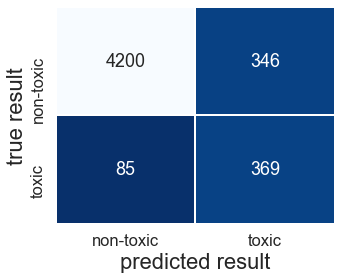

In [46]:
y_pred = model_toxic.predict(test_x)
y_pred = np.argmax(y_pred, axis=1)

#plot confusion matrix 
from sklearn import metrics
cm1 = metrics.confusion_matrix(test_label5000['toxic'], y_pred)

# visualize as heatmap
import seaborn as sns
sns.set(font_scale=1.5) # set fontsize 2

plt.figure(figsize=(5,4))

x_axis_labels = ['non-toxic','toxic']
y_axis_labels = ['non-toxic','toxic']

sns.heatmap(cm1, annot=True, fmt=".0f",  linewidths=1, cmap='Blues_r', cbar=False,
            xticklabels=x_axis_labels,  yticklabels=y_axis_labels)

plt.ylabel('true result', size=22)
plt.xlabel('predicted result', size=22)

plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
X_np=np.array(X)
X_np.shape

(70000, 784)

In [4]:
nX = 1000
data = X_np[0:nX,:]
labels = np.float64(y[0:nX])

In [5]:
data.shape

(1000, 784)

In [9]:
from pyflann import FLANN
import numpy as np
import scipy.sparse as sp

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.manifold.t_sne import _joint_probabilities_nn, _joint_probabilities
from sklearn.neighbors import BallTree
from sklearn.utils import check_array, check_random_state

import matplotlib.pyplot as plt

plt.style.use('ggplot')


string_types = "str"

def auto_params(dataset, target_precision):
    flann = FLANN()
    params = flann.build_index(dataset, algorithm="autotuned", target_precision=0.9);
    return params

class TSNE_mod(TSNE):
    def __init__(self, *args, **kwargs):
        self.rho = kwargs.pop("rho", 1.0)
        assert 0 < self.rho <= 1.0
        super(TSNE_mod, self).__init__(*args, **kwargs)
        
    def _fit(self, X, skip_num_points=0):
        """Fit the model using X as training data.
        Note that sparse arrays can only be handled by method='exact'.
        It is recommended that you convert your sparse array to dense
        (e.g. `X.toarray()`) if it fits in memory, or otherwise using a
        dimensionality reduction technique (e.g. TruncatedSVD).
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            If the metric is 'precomputed' X must be a square distance
            matrix. Otherwise it contains a sample per row. Note that this
            when method='barnes_hut', X cannot be a sparse array and if need be
            will be converted to a 32 bit float array. Method='exact' allows
            sparse arrays and 64bit floating point inputs.
        skip_num_points : int (optional, default:0)
            This does not compute the gradient for points with indices below
            `skip_num_points`. This is useful when computing transforms of new
            data where you'd like to keep the old data fixed.
        """
        if self.method not in ['barnes_hut', 'exact']:
            raise ValueError("'method' must be 'barnes_hut' or 'exact'")
        if self.angle < 0.0 or self.angle > 1.0:
            raise ValueError("'angle' must be between 0.0 - 1.0")
        if self.method == 'barnes_hut' and sp.issparse(X):
            raise TypeError('A sparse matrix was passed, but dense '
                            'data is required for method="barnes_hut". Use '
                            'X.toarray() to convert to a dense numpy array if '
                            'the array is small enough for it to fit in '
                            'memory. Otherwise consider dimensionality '
                            'reduction techniques (e.g. TruncatedSVD)')
        else:
            X = check_array(X, accept_sparse=['csr', 'csc', 'coo'],
                            dtype=np.float64)
        random_state = check_random_state(self.random_state)
        if self.early_exaggeration < 1.0:
            raise ValueError("early_exaggeration must be at least 1, but is "
                             "%f" % self.early_exaggeration)
        if self.n_iter < 200:
            raise ValueError("n_iter should be at least 200")
        if self.metric == "precomputed":
            if isinstance(self.init, string_types) and self.init == 'pca':
                raise ValueError("The parameter init=\"pca\" cannot be used "
                                 "with metric=\"precomputed\".")
            if X.shape[0] != X.shape[1]:
                raise ValueError("X should be a square distance matrix")
            distances = X
        else:
            if self.verbose:
                print("[t-SNE] Computing pairwise distances...")
            if self.metric == "euclidean":
                distances = pairwise_distances(X, metric=self.metric,
                                               squared=True)
            else:
                distances = pairwise_distances(X, metric=self.metric)
        if not np.all(distances >= 0):
            raise ValueError("All distances should be positive, either "
                             "the metric or precomputed distances given "
                             "as X are not correct")
        # Degrees of freedom of the Student's t-distribution. The suggestion
        # degrees_of_freedom = n_components - 1 comes from
        # "Learning a Parametric Embedding by Preserving Local Structure"
        # Laurens van der Maaten, 2009.
        degrees_of_freedom = max(self.n_components - 1.0, 1)
        n_samples = X.shape[0]
        # the number of nearest neighbors to find
        k = min(n_samples - 1, int(3. * self.perplexity + 1))
        neighbors_nn = None
        if self.method == 'barnes_hut':
            if self.verbose:
                print("[t-SNE] Computing %i nearest neighbors..." % k)
            if self.metric == 'precomputed':
                # Use the precomputed distances to find
                # the k nearest neighbors and their distances
                neighbors_nn = np.argsort(distances, axis=1)[:, :k]
            elif self.rho >= 1:
                # Find the nearest neighbors for every point
                bt = BallTree(X)
                # LvdM uses 3 * perplexity as the number of neighbors
                # And we add one to not count the data point itself
                # In the event that we have very small # of points
                # set the neighbors to n - 1
                distances_nn, neighbors_nn = bt.query(X, k=k + 1)
                neighbors_nn = neighbors_nn[:, 1:]
            elif self.rho < 1:
                # Use pyFLANN to find the nearest neighbors
                myflann = FLANN()
                testset = X
                params = myflann.build_index(testset, algorithm="autotuned", target_precision=self.rho, log_level='info');
                neighbors_nn, distances = myflann.nn_index(testset, k+1, checks=params["checks"])
                neighbors_nn = neighbors_nn[:, 1:]
                
            P = _joint_probabilities_nn(distances, neighbors_nn,
                                        self.perplexity, self.verbose)
        else:
            P = _joint_probabilities(distances, self.perplexity, self.verbose)
        assert np.all(np.isfinite(P)), "All probabilities should be finite"
        assert np.all(P >= 0), "All probabilities should be zero or positive"
        assert np.all(P <= 1), ("All probabilities should be less "
                                "or then equal to one")
        if isinstance(self.init, np.ndarray):
            X_embedded = self.init
        elif self.init == 'pca':
            pca = PCA(n_components=self.n_components, svd_solver='randomized',
                      random_state=random_state)
            X_embedded = pca.fit_transform(X)
        elif self.init == 'random':
            X_embedded = None
        else:
            raise ValueError("Unsupported initialization scheme: %s"
                             % self.init)
        return self._tsne(P, degrees_of_freedom, n_samples, random_state,
                          X_embedded=X_embedded,
                          neighbors=neighbors_nn,
                          skip_num_points=skip_num_points)


C:\Users\YC\Anaconda3\envs\test0\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
from sklearn.manifold import TSNE
tsne = TSNE_mod(perplexity=30, n_components=2, init='pca', n_iter=500, random_state=1941)
A=tsne.fit_transform(data).embedding_

TypeError: _joint_probabilities_nn() takes 3 positional arguments but 4 were given

In [21]:
from sklearn.manifold import TSNE

tSNE_embedding=TSNE(n_components=2,
          perplexity=30,
          verbose = 1,
          n_iter=1000, #default 1000
        random_state= 5,
         ).fit(data).embedding_

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 523.009411
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.031807
[t-SNE] KL divergence after 1000 iterations: 0.928040
